<a href="https://colab.research.google.com/github/Howlbeeb/ML-Projects/blob/master/Multi-Class_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Firstly Creating a dataset for MultiClass Classification


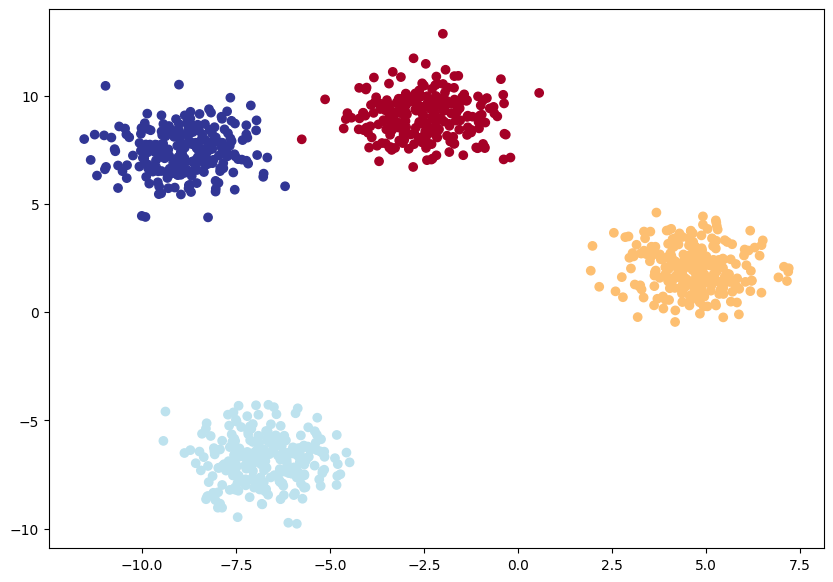

In [1]:
# Import Dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set hyperparameters for Blob creation dataset
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# Make blob dataset
X_blob,y_blob = make_blobs(n_samples=1000,n_features=NUM_FEATURES,centers=NUM_CLASSES, random_state=RANDOM_SEED)

#2 Turn data into Tensor
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

#3 Split the dataset
X_blob_train,X_blob_test,y_blob_train,y_blob_test = train_test_split(X_blob,y_blob,test_size=0.2, random_state=RANDOM_SEED)
# 4 Visualize and plot Data
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0],X_blob[:,1],c=y_blob, cmap=plt.cm.RdYlBu)

In [2]:
# Create device agnostic code
from torch import nn
device ='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Creating a multi-class Classification model

In [3]:
class BlobModel(nn.Module):
  def __init__(self,input_features,output_features,hidden_units=8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features,out_features=hidden_units),
        nn.ReLU6(),
        nn.Linear(in_features=hidden_units,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=output_features)
    )
  def forward(self,x):
    return self.linear_layer_stack(x)

model_5 = BlobModel(input_features=2,output_features=4,hidden_units=8).to(device)
model_5

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU6()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [5]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_5.parameters(),lr=0.1)

In [6]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
model_5(X_blob_train.to(device))[:5]

tensor([[ 0.6068, -0.6350, -0.6560, -0.3328],
        [ 0.5828, -0.6529, -0.6595, -0.3187],
        [ 0.4188, -0.5227, -0.1665, -0.1978],
        [ 0.3504, -0.4534, -0.2157, -0.2177],
        [ 0.4789, -0.5947, -0.5712, -0.2770]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [7]:
# Make prediction logits with model
y_logits = model_5(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[ 0.6253, -0.6706, -0.6911, -0.3472],
        [ 0.6210, -0.3735, -0.6682, -0.4595],
        [ 0.3631, -0.5135, -0.1406, -0.1530],
        [ 0.4455, -0.5481, -0.4898, -0.2582],
        [ 0.6787, -0.7136, -0.7465, -0.3614]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.5209, 0.1425, 0.1396, 0.1970],
        [0.5038, 0.1864, 0.1388, 0.1710],
        [0.3821, 0.1590, 0.2309, 0.2280],
        [0.4430, 0.1640, 0.1738, 0.2192],
        [0.5428, 0.1349, 0.1305, 0.1918]], device='cuda:0',
       grad_fn=<SliceBackward0>)


In [8]:
# Calculate Accuracy

def accuracy_fn(y_true,y_pred):
  correct = torch.eq(y_true,y_pred).sum().item()
  acc = (correct/len(y_pred)) *100
  return acc

In [9]:
## 4. Boundary decision using function from a raw source

import requests
from pathlib import Path
# download helper functions if not already downloaded
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py","wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions,plot_decision_boundary

helper_functions.py already exists


### Creating Training and Testing Loop

In [10]:
torch.cuda.manual_seed(42)

epochs = 100

# Putting data to target device
X_blob_train,y_blob_train = X_blob_train.to(device),y_blob_train.to(device)
X_blob_test,y_blob_test = X_blob_test.to(device),y_blob_test.to(device)

for epoch in range(epochs):
  model_5.train()
  # 1 Forward pass
  y_logits = model_5(X_blob_train)
  y_preds = torch.softmax(y_logits,dim=1).argmax(dim=1)
  #2 calculate the loss
  loss = loss_fn(y_logits,y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train,y_pred=y_preds)

  #3 Optimizer zero grad
  optimizer.zero_grad()

  #4 Loss backward
  loss.backward()

  #5 Optimizer step
  optimizer.step()

  # Testing
  model_5.eval()
  with torch.inference_mode():
    # do the forward pass
    test_logits = model_5(X_blob_test)
    test_preds = torch.softmax(test_logits,dim=1).argmax(dim=1)
    # calculate loss and acccuracy
    test_loss = loss_fn(test_logits,y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test,y_pred=test_preds)

  # print what's happening
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.45738, Acc: 25.12% | Test Loss: 1.37123, Test Acc: 24.50%
Epoch: 10 | Loss: 1.06871, Acc: 49.75% | Test Loss: 1.02108, Test Acc: 51.00%
Epoch: 20 | Loss: 0.71837, Acc: 74.50% | Test Loss: 0.69440, Test Acc: 71.00%
Epoch: 30 | Loss: 0.40852, Acc: 99.25% | Test Loss: 0.39299, Test Acc: 99.50%
Epoch: 40 | Loss: 0.20416, Acc: 99.88% | Test Loss: 0.19463, Test Acc: 100.00%
Epoch: 50 | Loss: 0.10997, Acc: 99.88% | Test Loss: 0.10376, Test Acc: 100.00%
Epoch: 60 | Loss: 0.06954, Acc: 99.88% | Test Loss: 0.06497, Test Acc: 100.00%
Epoch: 70 | Loss: 0.04936, Acc: 99.88% | Test Loss: 0.04556, Test Acc: 100.00%
Epoch: 80 | Loss: 0.03782, Acc: 99.88% | Test Loss: 0.03442, Test Acc: 100.00%
Epoch: 90 | Loss: 0.03052, Acc: 99.88% | Test Loss: 0.02737, Test Acc: 100.00%


In [13]:
# make some Evaluation
model_5.eval()
with torch.inference_mode():
  y_logits = model_5(X_blob_test)
y_logits[:5]

tensor([[ 1.4219,  5.3820, -2.5827, -5.8545],
        [-0.1581, -4.4771, -3.4565,  3.6780],
        [-2.5014, -0.0997,  5.8968, -1.1253],
        [ 0.7467,  4.5761, -1.7675, -4.8691],
        [ 3.9821,  0.0445, -6.8378, -1.7718]], device='cuda:0')

In [14]:
y_preds_probs = torch.softmax(y_logits,dim=1)
# Converting it to Labels
y_labels = y_preds_probs.argmax(dim=1)
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_labels)}%")

Predictions: tensor([1, 0, 2, 2, 0, 0, 0, 1, 3, 0], device='cuda:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Test accuracy: 100.0%


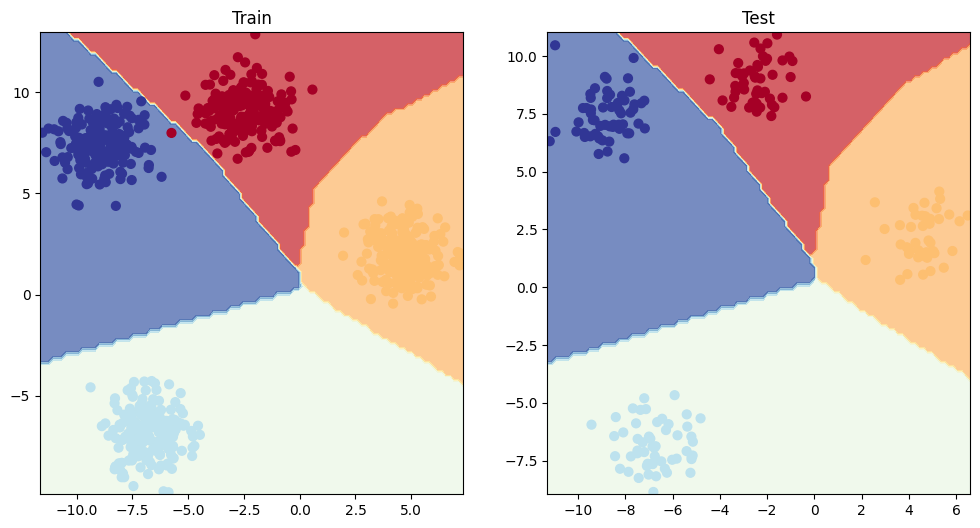

In [16]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_5, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_5, X_blob_test, y_blob_test)

In [18]:
try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics==0.9.3 # this is the version we're using in this notebook (later versions exist here: https://torchmetrics.readthedocs.io/en/stable/generated/CHANGELOG.html#changelog)
    from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
torchmetrics_accuracy(y_labels, y_blob_test)

tensor(1., device='cuda:0')